### 신문기자 챗봇 만들기
 - 랭그래프도 펑션 콜링(도구 호출) 가능
 - 사용자가 주제를 제시하면 인터넷을 검색하여 최신 이슈를 기반으로 세부 주제를 선정하고, 그 주제를 검색해서 최종 기사를 작성하는 신문기자 챗봇 만들기

In [2]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini", temperature=0.01)
model.invoke('안녕하세요') # 언어모델 테스트

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BquMNUjUpHR4SlFtAKq51zEBOwqdB', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--817facab-78f3-4db3-bb8f-ba2a33011fef-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [3]:
# 상태 설정
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    State 클래스는 TypedDict를 상속받습니다.

    속성:
        messages (Annotated[list[str], add_messages]): 메시지들은 "list" 타입을 가집니다.
        주석에 있는 'add_messages' 함수는 이 상태 키가 어떻게 업데이트되어야 하는지를 정의합니다.
        (이 경우, 메시지를 덮어쓰는 대신 리스트에 추가합니다.)
    """
    messages: Annotated[list[str], add_messages]

# StateGraph 클래스를 사용하여 State 타입의 그래프 생성
graph_builder = StateGraph(State)

In [ ]:
# 도구 등록하기
from langchain_core.tools import tool
from datetime import datetime
import pytz
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper

from langchain_community.document_loaders import WebBaseLoader

# 도구 함수 정의
@tool
def get_current_time(timezone: str, location: str) -> str:
    """현재 시각을 반환하는 함수"""
    try:
        tz = pytz.timezone(timezone)
        now = datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")
        result = f'{timezone} ({location}) 현재 시각 {now}'
        return result
    except pytz.UnknownTimeZoneError:
        return f"알 수 없는 타임존: {timezone}"
    
@tool
def get_web_search(query: str, search_period: str='m') -> str:
    """
    웹 검색을 수행하는 함수.

    Args:
        query (str): 검색어
        search_period (str): 검색 기간 (e.g., "w" for past week, "m" for past month (default), "y" for past year, "d" for past day)

    Returns:
        str: 검색 결과        
    """
    # Returns는 반환값이 단수든 복수든 Returns로 써야 한다. 문서화 규칙
    wrapper = DuckDuckGoSearchAPIWrapper(
        region="kr-kr",
        time=search_period,
    )

    print('\n------ WEB SEARCH -------')
    print(query)
    print(search_period)

    search = DuckDuckGoSearchResults(
        api_wrapper=wrapper,
        results_separator=';\n'
    )

    searched = search.invoke(query)

    for i, result in enumerate(searched.split(';\n')):
        print(f'{i+1}. {result}')

    return searched

# 도구 바인딩
tools = [get_current_time, get_web_search,]     

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
# get_current_time 테스트
tools[0].invoke({"timezone": "Asia/Seoul", "location": "서울"})

'Asia/Seoul (서울) 현재 시각 2025-07-08 13:36:44'

In [6]:
# get_web_search 테스트
tools[1].invoke({"query": "파이썬", "search_period": "m"})


------ WEB SEARCH -------
파이썬
m
1. snippet: Jun 14, 2025 · 2.7. PEP [편집] PEP (Python Enhancement Proposals, 파이썬 개선 제안서)란 …, title: Python - 나무위키, link: https://namu.wiki/w/Python
2. snippet: Jun 18, 2025 · 왜 배우는가? 파이썬 (Python)은 1991년 귀도 반 로섬 (Guido van Rossum)이 …, title: [파이썬 기초강의] 완전 초보도 이해하는 기초부터 튼튼하게 ..., link: https://blog.naver.com/blogtest12345/223903734238
3. snippet: Jul 1, 2025 · 이 글은 비전공자분들이 파이썬을 독학으로 배우는 데 필요한 모든 정보를 담은 …, title: 파이썬 독학 비전공자도 성공하는 코딩 입문 로드맵 A to Z, link: https://jkinvest1004.tistory.com/entry/파이썬-독학-비전공자도-성공하는-코딩-입문-로드맵-A-to-Z
4. snippet: Jun 12, 2025 · Visual Studio에서 지원되는 Python 인터프리터의 전체 목록을 검토하고 설치 …, title: Python 인터프리터 선택 및 설치 - Visual Studio (Windows), link: https://learn.microsoft.com/ko-kr/visualstudio/python/installing-python-interpreters?view=vs-2022


'snippet: Jun 14, 2025 · 2.7. PEP [편집] PEP (Python Enhancement Proposals, 파이썬 개선 제안서)란 …, title: Python - 나무위키, link: https://namu.wiki/w/Python;\nsnippet: Jun 18, 2025 · 왜 배우는가? 파이썬 (Python)은 1991년 귀도 반 로섬 (Guido van Rossum)이 …, title: [파이썬 기초강의] 완전 초보도 이해하는 기초부터 튼튼하게 ..., link: https://blog.naver.com/blogtest12345/223903734238;\nsnippet: Jul 1, 2025 · 이 글은 비전공자분들이 파이썬을 독학으로 배우는 데 필요한 모든 정보를 담은 …, title: 파이썬 독학 비전공자도 성공하는 코딩 입문 로드맵 A to Z, link: https://jkinvest1004.tistory.com/entry/파이썬-독학-비전공자도-성공하는-코딩-입문-로드맵-A-to-Z;\nsnippet: Jun 12, 2025 · Visual Studio에서 지원되는 Python 인터프리터의 전체 목록을 검토하고 설치 …, title: Python 인터프리터 선택 및 설치 - Visual Studio (Windows), link: https://learn.microsoft.com/ko-kr/visualstudio/python/installing-python-interpreters?view=vs-2022'

In [7]:
# 도구 목록 확인
for tool in tools:
    print(tool.name, tool)

get_current_time name='get_current_time' description='현재 시각을 반환하는 함수' args_schema=<class 'langchain_core.utils.pydantic.get_current_time'> func=<function get_current_time at 0x000002D4C05E5A80>
get_web_search name='get_web_search' description='웹 검색을 수행하는 함수.\n\nArgs:\n    query (str): 검색어\n    search_period (str): 검색 기간 (e.g., "w" for past week (default), "m" for past month, "y" for past year, "d" for past day)\n\nReturns:\n    str: 검색 결과' args_schema=<class 'langchain_core.utils.pydantic.get_web_search'> func=<function get_web_search at 0x000002D4C063E8E0>


In [8]:
# 모델에 도구 연결 및 generate 노드 생성 
model_with_tools = model.bind_tools(tools) 

def generate(state: State):
    """
    주어진 상태를 기반으로 챗봇의 응답 메시지를 생성합니다.

    매개변수:
    state (State): 현재 대화 상태를 나타내는 객체로, 이전 메시지들이 포함되어 있습니다.

    반환값:
    dict: 모델이 생성한 응답 메시지를 포함하는 딕셔너리
        형식은 {"messages": model_with_tools.invoke(state["messages])}
    """
    return {"messages": model_with_tools.invoke(state["messages"])}

graph_builder.add_node("generate", generate)

In [9]:
# 도구를 사용하는 노드 클래스 생성하기
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """
    도구를 실행하는 노드 클래스입니다. 마지막 AIMessage에서 요청된 도구를 실행합니다.
    Attributes:
        tools_by_name (dict): 도구 이름을 키로 하고 도구 객체를 값으로 가지는 사전입니다.
    Methods:
        __init__(tools: list): 도구 객체들의 리스트를 받아서 초기화합니다.
        __call__(inputs: dict): 입력 메시지를 받아서 도구를 실행하고 결과 메시지를 반환합니다.
    """
    """A node that runs the tools requested in the last AIMessage"""

    def __init__(self, tools:list) -> None:
        # 초기화 메서드 tools_by_name은 도구의 이름과 해당 도구(객체)를 딕셔너리 형태로 저장
        self.tools_by_name = {tool.name: tool for tool in tools} # 딕셔너리 컴프리헨션(dictionary comprehension)

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            # inputs에 messsages가 있으면 messages를 가져오고 없으면 빈 리스트 가져오기
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            # 초기화 메서드에서 만든 tools_by_name 딕셔너리를 호출
            # tools_by_name만 쓰면 함수 안의 지역 변수, tools_by_name은 클래스 인스턴스에 저장된 진짜 변수
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": messages + outputs}
    
tool_node = BasicToolNode(tools=tools)
graph_builder = graph_builder.add_node("tools", tool_node)

### 라우터 설정하기
 - AI 에이전트가 랭그래프 내에서 스스로 다음 경로를 선택해야 할 때 라우터(router)를 활용합니다.
 - 상황에 따라 방향을 결정하는 것을 라우팅(routing)이라고 합니다.
 - 이 때 조건에 따라 활성화되거나 비활성화되는 조건부 엣지(conditional edge)를 사용합니다.
 - 더 자세한 라우터는 13-2장에서

In [ ]:
# 언어 모델이 도구 사용 여부를 판단하도록 라우터 설정하기
def route_tools(state: State):
    """
    마지막 메시지에 도구 호출이 있는 경우 ToolNode로 라우팅하고,
    그렇지 않은 경우 끝으로 라우팅하기 위해 conditional_edge에서 사용합니다.
    """
    # State 클래스는 dict이라 list가 올 일은 없지만 혹시 모를 상황에 대비한 안정장치용 범용 코드인듯?
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"tool_dege 입력 상태에서 메시지를 찾을 수 없습니다: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

graph_builder.add_edge(START, "generate")
graph_builder.add_conditional_edges(
    "generate",
    route_tools,
    {"tools": "tools", END: END},
)

# 도구가 호출될 때마다 다음 단계를 결정하기 위해 챗봇으로 돌아감
graph_builder.add_edge("tools", "generate")
graph = graph_builder.compile()

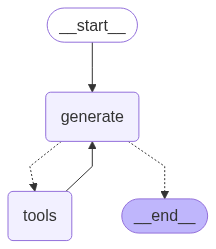

In [11]:
# 그래프 출력하기
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

### 도구 테스트하고 기사 작성하기

In [ ]:
# get_current_time 테스트
from langchain_core.messages import AIMessageChunk, HumanMessage

inputs = [HumanMessage(content="지금 서울 몇 시야?")]

gathered = None

# 파이썬의 튜플 언팩킹
# graph.stream()이 반복할 때마다 (msg, metadata) 형태의 튜플을 반환하기 때문에, for문에서 각각을 msg, metadata라는 두 변수로 자동 분리해서 받는 것
for msg, metadata in graph.stream({"messages": inputs}, stream_mode="messages"):
    if isinstance(msg, AIMessageChunk):
        print(msg.content, end="")

        if gathered is None:
            gathered = msg
        else:
            # gathered는 AIMessageChunk 객체이고 덧셈 연산자를 연산자 오버로딩해서 객체 + 객체 가 가능
            gathered = gathered + msg

gathered

현재 서울은 2025년 7월 8일 13시 49분입니다.

AIMessageChunk(content='현재 서울은 2025년 7월 8일 13시 49분입니다.', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_QeTrOU7yIBuAIgEF3alitvGs', 'function': {'arguments': '{"timezone":"Asia/Seoul","location":"서울"}', 'name': 'get_current_time'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_callsstop', 'model_name': 'gpt-4o-mini-2024-07-18gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93cfp_34a54ae93c', 'service_tier': 'defaultdefault'}, id='run--c92df4aa-446d-413b-b86d-8ae07849a393', tool_calls=[{'name': 'get_current_time', 'args': {'timezone': 'Asia/Seoul', 'location': '서울'}, 'id': 'call_QeTrOU7yIBuAIgEF3alitvGs', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'get_current_time', 'args': '{"timezone":"Asia/Seoul","location":"서울"}', 'id': 'call_QeTrOU7yIBuAIgEF3alitvGs', 'index': 0, 'type': 'tool_call_chunk'}])

In [14]:
# 프롬프트 설정하고 기사 작성하기
from langchain_core.messages import AIMessageChunk, SystemMessage

about = "서울 월드컵 경기장 잔디 문제"

inputs = [SystemMessage(content=f"""
너는 신문기자이다.
최근 {about}에 대해 비판하는 심층 분석 기사를 쓰려고 한다.
- 최근 어떤 이슈가 있는지 검색하고, 사람들이 제일 관심있어 할만한 주제를 선정하고, 왜 선정했는지 말해줘.
- 그 내용으로 원고를 작성하기 위한 목차를 만들고, 목차 내용을 채우기 위해 추가로 검색할 내용을 리스트로 정리해봐.
- 검색할 리스트를 토대로 재검색해.
- 목차에 있는 내용을 작성하기 위해 더 검색이 필요한 정보가 있는지 확인하고, 있다면 추가로 검색해.
- 검색된 결과에 원하는 정보를 찾지 못했다면 다른 검색어로 재검색해도 좋아.

더 이상 검색할 내용이 없다면, 조선일보 신문 기사 형식으로 최종 기사를 작성한다.
제목, 부제, 리드문, 본문의 구성으로 작성한다. 본문 내용은 심층 분석 기사에 맞게 구체적이고 깊이 있게 작성해야 한다.
                        
""")]

for msg, metadata in graph.stream({"messages": inputs}, stream_mode="messages"):
    if isinstance(msg, AIMessageChunk):
        print(msg.content, end='')


------ WEB SEARCH -------
서울 월드컵 경기장 잔디 문제
w
1. snippet: 5 hours ago · 최근 A매치는 꾸준히 구름 관중이 모였다. 2025년 3번의 홈경기에서 평균 관중은 3만 9,568명. 3월 2연전 당시 오만전 3만 5,212명 (고양종합운동장), 요르단전 …, title: ‘4426명? 흥행 실패 조짐’ 6년 만에 열린 동아시안컵…손흥민 ..., link: https://mksports.co.kr/news/sports/11362044
2. snippet: 1 day ago · 여기에 서울월드컵경기장의 잔디 상태가 악화되자, 대표팀마저 지난해 10월 이곳에서 이라크와 2026북중미월드컵 아시아 최종예선 B조 4차전도 치렀다., title: [SD 용인 라이브] 새로운 '축구 도시' 정착? 홍보용 개최의 한계 ..., link: https://sports.news.nate.com/view/20250707n33444
3. snippet: 6 days ago · 경기도는 수원월드컵경기장 주차장 부지에 선수촌을 건립하려 했으나 고층 건물 건설이 어려워 계획을 변경했습니다. 이에 따라 도는 행정동은 주차장 부지에 짓고 선수촌 훈련시설은 인조 잔디 …, title: 경기도 선수촌 훈련시설, 수원월드컵경기장 인조구장에 건립 ..., link: https://www.joongboo.com/news/articleView.html?idxno=363697070
4. snippet: 4 days ago · 경기장 문제도 풀어야 할 숙제다. 그는 "우리나라 경기장에는 상업적인 시설이 있다. 국제축구연맹 (FIFA), AFC에선 이른바 '클린 스타디움'이라고 해서, 대회 한 달 전에는 경기장을 …, title: 정몽규 "국내 경기장 내 상업 시설, 아시안컵 유치 걸림돌", link: https://www.fmkorea.com/8607785566
최근 서울 월드컵 경기장 잔디 문제에 대한 이슈가 여러 매체에서 보도되고 있습니다. 특히, 잔디